In [188]:
from ogs6py import ogs
import os
import ogs6py
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time
import math
from types import MethodType
import pandas as pd
from pathlib import Path

pi = math.pi
%matplotlib inline
plt.rcParams['text.usetex'] = True

# Great Cell - 3D

<!-- ![Benchmarking idea](./figures/greatcell_benchmarking.png "Benchmarking idea.") -->


<img src="./figures/mechanical_3d.png#one-half" alt="Benchmarking idea." style="width:300px;">

<div style="display: flex;">
  <img src="./figures/YoungModulus_2D.png" alt="Young's modulus and Poisson's ratio for the main sample and rubber sheath" style="width:400px;">
  <img src="./figures/model_3D.png" alt="Schematic view of 3D model" style="width:400px;">
</div>

### Path

In [189]:
prj_path='./'
results_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not results_dir.exists():
    results_dir.mkdir(parents=True)

In [190]:
# prj_name = "great_cell_3d_SDprocess.prj" # SD process
# #prj_name = "great_cell_3d.prj" # THMPhaseField process

# ogs_path = "~/master_test/build_master_modifiedE/bin/ogs" #

In [191]:
def get_paths(case): # using VPF process
    prj_name = "great_cell_3d.prj"
    ogs_path = "~/dynamicPhasefield/build-THMPF-updateTao-dynamic/bin/ogs" #

    if case in ['M1_triaxial', 'M1_axisymmetric', "M1_triaxial_differentMaterial", "M1_axisymmetric_differentMaterial"]: # using SD process
        prj_name = "great_cell_3d_SDprocess.prj"
        ogs_path = "~/master_test/build_master_modifiedE/bin/ogs" 

    return ogs_path, prj_name

## Definition of functions

### Set Young's modulus and Poisson's ratio for the main sample and rubber sheath


<!-- <div style="display: flex;">
  <img src="./figures/YoungModulus_2D.png" alt="Young's modulus and Poisson's ratio for the main sample and rubber sheath" style="width:400px;">
  <img src="./figures/model_3D.png" alt="Schematic view of 3D model" style="width:400px;">
</div> -->

In [192]:
def set_E_nu(in_m, out_m,young_sample,nu_sample,young_sheath, nu_sheath):
    m = pv.read(f'{prj_path}/mesh/{in_m}')
    n_cells = m.n_cells
    
    young = np.zeros(n_cells)
    nu = np.zeros(n_cells)

    for i in range(n_cells):
        cell = m.GetCell(i)
        x_min,x_max,y_min,y_max,z_min,z_max = cell.GetBounds()
        
        x = (x_min+x_max)/2
        y = (y_min+y_max)/2
        if (x**2 + y**2) > 0.097**2:
            young[i] = young_sheath
            nu[i] = nu_sheath
        else:
            young[i] = young_sample
            nu[i] = nu_sample

    m.cell_data['E'] = young
    m.cell_data['nu'] = nu

    m.save(f'{prj_path}/mesh/{out_m}',False)

### Set initial phase field (fracture) and pressure

For the fractured cases, we consider two scenarios: 2-wing fracture and one-wing fracture. You can use the following functions to set the initial phase field:

1. Two-wing fracture: $[-0.065, 0.065] \times \{0\}$
2. One-wing fracture: $[0, 0.065] \times \{0\}$


Note: We do not call this function for mechanical deformation in sound samples, where there is an absence of fracture.

In [193]:
initial_pressure = 2.e6

In [194]:
def set_crack(in_m,out_m, crack_type, initial_pressure):
    m = pv.read(f'{prj_path}/mesh/{in_m}')
    n_points = m.number_of_points
    pt_coords = m.points

    phasefield = np.ones(n_points)
    pressure = np.zeros(n_points)
    
    r1 = 0.065
    h1 = 0.002

    for point_id in range(0, n_points):
        x=pt_coords[point_id, 0]
        y=pt_coords[point_id, 1]
        z=pt_coords[point_id, 2]

        
        if crack_type == 'full':
            if abs(x) < r1 and abs(y) < h1 :
                phasefield[point_id] =  0
                pressure[point_id] =  initial_pressure
            else:
                phasefield[point_id] = 1
                pressure[point_id] =  0.
                
        elif crack_type == 'half':
            if 0 < x < r1 and abs(y) < h1  and z > 0.04 and z < 0.16:
                phasefield[point_id] =  0
                pressure[point_id] =  initial_pressure
            else:
                phasefield[point_id] = 1
                pressure[point_id] =  0.
                
        else:  
                phasefield = np.ones(n_points)
                pressure = np.zeros(n_points)

    m.point_data['pf-ic'] = phasefield
    m.point_data['p-ic'] = pressure

    m.save(f'{prj_path}/mesh/{out_m}',False)

### Set the loading conditions for BAGs (PEEs) and STRIP (DSSs)

Assign loading Conditions for BAG segments and apply on STRIP segments loading average of surrounding BAG segments.
<!-- ![Schematic view of Great Cell BC](./figures/greatcell_loading_schematic_xy.png#one-half "Schematic view of Great Cell BC.") -->

<img src="./figures/greatcell_loading_schematic_xy.png#one-half" alt="Schematic view of Great Cell BC." style="width:400px;">


In [195]:
# define method to be assigned to model, to replace a specific curve, given by name 
# (analogue to replace_parameter method)
def replace_curve(self, name=None, value=None, coords=None, parametertype=None, valuetag="values", coordstag="coords"):
    root = self._get_root()
    parameterpath = "./curves/curve"
    parameterpointer = self._get_parameter_pointer(root, name, parameterpath)
    self._set_type_value(parameterpointer, value, parametertype, valuetag=valuetag)
    self._set_type_value(parameterpointer, coords, parametertype, valuetag=coordstag)

# define method to be assigned to model, to calculate loads for all STRIP BC from BAG BC and assign them, 
# when not done by apply_F_to_all
def set_strips(self, valuetag="values", coordstag="coords"):
    root = self._get_root()
    parameterpath = "./curves/curve"
    
    for i in range(1,17):
        parameterpointer_a = self._get_parameter_pointer(root, "BAG_"+str(i)+"_SURFACE_CURVE", parameterpath)
        parameterpointer_b = self._get_parameter_pointer(root, "BAG_"+str(i%16+1)+"_SURFACE_CURVE", parameterpath)
        for paramproperty in parameterpointer_a:
            if paramproperty.tag == valuetag:
                F_X_a = [float(x) for x in paramproperty.text.split(' ')]
            elif paramproperty.tag == coordstag:
                coords = paramproperty.text
        for paramproperty in parameterpointer_b:
            if paramproperty.tag == valuetag:
                F_X_b = [float(x) for x in paramproperty.text.split(' ')]
        F_a = [-x for x in F_X_a]
        F_b = [-x for x in F_X_b]
        F = [0.5*(F_a[i]+F_b[i]) for i in range(len(F_a))]
        values_F = ' '.join(map(str, F))
        self.replace_curve(name="STRIP_"+str(i)+"_SURFACE_CURVE",value=values_F, coords=coords)


In [196]:
def apply_F_to_BAG(model,F,n,coords='0 1 2 3 4', value_mult = [0,1,1,1,1]):
    F_v = [-x*F for x in value_mult]
    values_F_v = ' '.join(map(str, F_v))
    model.replace_curve(name="BAG_"+str(n)+"_SURFACE_CURVE",value=values_F_v, coords=coords)
    
def apply_F_to_STRIP(model,F_a, F_b,n,coords='0 1 2 3 4', value_mult = [0,1,1,1,1]):
    F = 0.5*(F_a+F_b)
    F_v = [-x*F for x in value_mult]
    values_F_v = ' '.join(map(str, F_v))
    model.replace_curve(name="STRIP_"+str(n)+"_SURFACE_CURVE",value=values_F_v, coords=coords)
    
def apply_F_to_TOP(model,F_top,coords='0 1 2 3 4', value_mult = [0,1,1,1,1]):
    F_top = [x*F_top for x in value_mult]
    values_F_top = ' '.join(map(str, F_top))
    model.replace_curve(name="TOP_SURFACE_DZ_CURVE",value=values_F_top, coords=coords)
    
def apply_F_to_all(model,F_values,t_coords='0 1 2 3 4', value_mult = [0,0,0,1,1]):
    # apply given F_values as BC on BAG and mean values on STRIP in between, 
    # with given time coordinates t_coords in given loading steps value_mult
    # F_values for example: [10e6,0,0,0,5e6,0,0,0,10e6,0,0,0,5e6,0,0,0]
    for i in range(1,17):
        apply_F_to_BAG(model,F_values[i-1],i,t_coords,value_mult)
        apply_F_to_STRIP(model,F_values[i-1], F_values[i%16],i,t_coords,value_mult)

### Different loading conditions 


 M1 loading includes:
   - M1_triaxial
   - M1_axisymmetric
   
|                   | **True Triaxial**       | **Axisymmetric**       |
|-------------------|-------------------------|------------------------|
|                   | PEEs 1 & 1a: 7.73 MPa    | PEEs 1 & 1a: 7.71 MPa   |
|                   | PEEs 2 & 2a: 5.70 MPa    | PEEs 2 & 2a: 7.70 MPa   |
|                   | PEEs 3 & 3a: 4.39 MPa    | PEEs 3 & 3a: 8.30 MPa   |
|                   | PEEs 4 & 4a: 2.40 MPa    | PEEs 4 & 4a: 7.80 MPa   |
|                   | PEEs 5 & 5a: 2.30 MPa    | PEEs 5 & 5a: 7.74 MPa   |
|                   | PEEs 6 & 6a: 4.00 MPa    | PEEs 6 & 6a: 7.70 MPa   |
|                   | PEEs 7 & 5a: 6.40 MPa    | PEEs 7 & 7a: 8.30 MPa   |
|                   | PEEs 8 & 8a: 7.70 MPa    | PEEs 8 & 8a: 7.72 MPa   |
|                   | DSSs: average of loads of adjacent PEEs | DSSs: average of loads of adjacent PEEs |



Hint: You can set the load at the top surface for 3D cases using `apply_F_to_TOP(model11__, -10.e6)`. We set the axial `load 10 MPa` 

In [197]:
def apply_xy_load(n_angle, prj_name):
    ##################
    # n angel 0,1,2,3 for 0, 22.5, 45, 67.5 °
    ##################
    
    model1 = ogs.OGS(INPUT_FILE=prj_path+prj_name, PROJECT_FILE=prj_path+prj_name, MKL=True)
    model1.replace_curve = MethodType(replace_curve, model1)
    
    #set every BC zero
    apply_F_to_all(model1,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        
    for i in [1,5,9,13]:
        apply_F_to_BAG(model1,8e6,n_angle+i)

    model1.write_input()
    
def apply_M1_load(case, prj_name):
    if case == 'M1_triaxial' or case == 'M1_triaxial_differentMaterial':
        model11_ = ogs.OGS(INPUT_FILE=prj_path+prj_name, PROJECT_FILE=prj_path+prj_name, MKL=True)
        model11_.replace_curve = MethodType(replace_curve, model11_)
        apply_F_to_all(model11_,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], value_mult = [1,1,1,1,1])        
        apply_F_to_all(model11_,[7.73e6,5.7e6,4.39e6,2.4e6,2.3e6,4e6,6.4e6,7.7e6,7.73e6,5.7e6,4.39e6,2.4e6,2.3e6,4e6,6.4e6,7.7e6])
        apply_F_to_TOP(model11_,-10.e6)
        model11_.write_input()
    elif case == 'M1_axisymmetric' or case == 'M1_axisymmetric_differentMaterial':
        model11__ = ogs.OGS(INPUT_FILE=prj_path+prj_name, PROJECT_FILE=prj_path+prj_name, MKL=True)
        model11__.replace_curve = MethodType(replace_curve, model11__)
        apply_F_to_all(model11__,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
        apply_F_to_all(model11__,[7.71e6,7.7e6,8.3e6,7.8e6,7.74e6,7.7e6,8.3e6,7.72e6,7.71e6,7.7e6,8.3e6,7.8e6,7.74e6,7.7e6,8.3e6,7.72e6])
        apply_F_to_TOP(model11__,-10.e6)
        model11__.write_input()
    else:
        print(f'Oops somethings wrong in the code. Wrong input "{case}"" should not have made it this far...')
        
    
    

### Run the simulations

We have several options to choose from: `M1_triaxial`, `M1_axisymmetric`, `M3a`, `M3b`, `HM3a`, `HM3b`.

1. Material properties of the sample and rubber sheath are introduced here.

2. In `M1_triaxial` and `M1_axisymmetric`, we only run simulations for mechanical deformation in the absence of fracture (phase field is set to 1 for the entire domain).




In [202]:
def run_benchmark(case):
    #case is one of [M1_triaxial, M1_axisymmetric, M3a, M3b, HM3a, HM3b]
    in_m = "mesh_GreatCell_vericalFracture_OGSNR_pf_ic_MIDs.vtu"
    young_sheath = 0.1e9
    nu_sheath = 0.4
    
    # introduce crack
    if case in ['M1_triaxial','M1_axisymmetric']:        
        ogs_path, prj_name = get_paths(case)
        print(f"OGS Path: {ogs_path}, PRJ File: {prj_name}")
        
        young_sample = 3.85e9 
        nu_sample =  0.4

        set_E_nu(in_m,in_m,young_sample,nu_sample,young_sheath, nu_sheath)
        
        m = pv.read(f'{prj_path}/mesh/{in_m}')
        n_points = m.number_of_points
        pt_coords = m.points
        phasefield = np.ones(n_points)
        m.point_data['pf-ic'] = phasefield
        m.save(f'{prj_path}/mesh/{in_m}',False)
        
        out_dir = f"results_{case}"
        if not os.path.exists(f"./{results_dir}/{out_dir}"):
            os.makedirs(f"./{results_dir}/{out_dir}")  
        
        apply_M1_load(case, prj_name)
        #run ogs
        t0 = time.time()
        print(">>> OGS started execution ... <<<")
        print(prj_name)
        !{ogs_path} {prj_path+prj_name} -o  {results_dir}/{out_dir} > {results_dir}/{out_dir}/log.txt
        tf = time.time()
        print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")
        
    elif case in ["M1_triaxial_differentMaterial", "M1_axisymmetric_differentMaterial"]:  
        ogs_path, prj_name = get_paths(case)
        print(f"OGS Path: {ogs_path}, PRJ File: {prj_name}")
        
        materials = {
            "Gneiss": {"young_sample": 83.9e9, "nu_sample": 0.21},
            "Greywacke": {"young_sample": 26.87e9, "nu_sample": 0.27},
            "PMMA": {"young_sample": 3.85e9, "nu_sample": 0.4},
        }

        # Loop through each material
        for material_name, properties in materials.items():
            young_sample = properties["young_sample"]
            nu_sample = properties["nu_sample"]
            set_E_nu(in_m,in_m,young_sample,nu_sample,young_sheath, nu_sheath)

            m = pv.read(f'{prj_path}/mesh/{in_m}')
            n_points = m.number_of_points
            pt_coords = m.points
            phasefield = np.ones(n_points)
            m.point_data['pf-ic'] = phasefield
            m.save(f'{prj_path}/mesh/{in_m}',False)

            out_dir = f"results_{case}_{material_name}"
            if not os.path.exists(f"./{results_dir}/{out_dir}"):
                os.makedirs(f"./{results_dir}/{out_dir}")  

            apply_M1_load(case, prj_name)
            #run ogs
            t0 = time.time()
            print(">>> OGS started execution ... <<<")
            print(prj_name)
            !{ogs_path} {prj_path+prj_name} -o  {results_dir}/{out_dir} > {results_dir}/{out_dir}/log.txt
            tf = time.time()
            print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.") 

    elif case in ['M3a','HM3a','M3b','HM3b']:

        ogs_path, prj_name = get_paths(case)
        print(f"OGS Path: {ogs_path}, PRJ File: {prj_name}")
        
        if case =='M3a':
            set_crack(in_m,in_m, 'full', 0.0)          
        if case =='HM3a':
            set_crack(in_m,in_m, 'full', initial_pressure)
        if case =='M3b':
            set_crack(in_m,in_m, 'half', 0.0)            
        if case =='HM3b':
            set_crack(in_m,in_m, 'half', initial_pressure)

        for i in [0,1,2,3]:
            apply_xy_load(i, prj_name)

            out_dir = f"results_{case}_angle{i*22.5}"
            if not os.path.exists(f"./{results_dir}/{out_dir}"):
                os.makedirs(f"./{results_dir}/{out_dir}") 

            #run ogs
            t0 = time.time()
            print(">>> OGS started execution ... <<<")
            print(prj_name)
            !{ogs_path} {prj_path+prj_name} -o  {results_dir}/{out_dir} > {results_dir}/{out_dir}/log.txt
            tf = time.time()
            print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")
            
    else:
        print(f'{case} not a valid case. Chose one of ["M1_triaxial", "M1_axisymmetric", "M3a", "M3b", "HM3a", "HM3b"]')
        
      
    
        
    

# Post-processing Functions

The volumetric strain is extracted at locations where `abs(x[2] - 0.1) < 1e-6` and `abs(x[0]**2 + x[1]**2 - 0.065**2) < 1e-6`. This means that data is extracted at the `middle of the sample in the z-direction` and at a radial distance of `0.065`.

Hint: The plots are based on extracting data from the last time step vtu file. In case you need to extract data from another timestep output, you can change the file name to `GreatCell_3D_ts_4_t_4.000000.vtu`.

In [199]:
def get_vol_strain(out):
    out_dir=out
    mesh = pv.read(f"{out_dir}/GreatCell_3D_ts_4_t_4.000000.vtu")
    phase_field = np.ones((len(mesh.points),1))
    eps=mesh.point_data["epsilon"]
    disp=mesh.point_data["displacement"]
    eps_v=[]
    eps_r=[]
    phi=[]
    u_r=[]
    for node_id, x in enumerate(mesh.points):
        if (abs(x[2]-0.1)<1e-6 and abs(x[0]**2+x[1]**2-0.065**2)<1e-5):

            eps_vol=abs(eps[node_id][0]+eps[node_id][1]+eps[node_id][2])
            eps_v.append(eps_vol)
            theta = math.atan2(x[1], x[0])
            theta_p=theta
            if theta_p < 0:
                theta_p += 2*math.pi
            phi.append(theta_p)

    sort_idx = np.argsort(phi)
    phi_sorted = [phi[i] for i in sort_idx]
    eps_v_sorted = [eps_v[i] for i in  sort_idx]
   
    return np.array(phi_sorted), np.array(eps_v_sorted)


In [200]:
def strain_magnitude(e11, e22, e33, e12, e23, e31): 
    strain_mag = np.sqrt(e11**2 + e22**2 + e33**2 + 2*e12**2 + 2*e23**2 + 2*e31**2) 
    return strain_mag 

def displacement_magnitude(u1, u2, u3,theta): 
    disp_mag = u1 * np.cos(theta) + u2 * np.sin(theta)
    return disp_mag 


def get_surf_strain(out):

    out_dir=out
    if os.path.exists(f"{out_dir}/GreatCell_3D_ts_4_t_4.000000.vtu"):
        mesh = pv.read(f"{out_dir}/GreatCell_3D_ts_4_t_4.000000.vtu")
        mesh_0 = pv.read(f"{out_dir}/GreatCell_3D_ts_2_t_2.000000.vtu")
    else:
        print('There is no result file with that naming...')
    disp= mesh.point_data["displacement"]
    disp_0= mesh_0.point_data["displacement"]
    
    phi=[]
    xyz = []
    u = []
    u_0 = []
    # getting points at radius of 0.097
    for node_id, x in enumerate(mesh.points):
        if (abs(x[2]-0.1)<1e-6 and abs(x[0]**2+x[1]**2-0.090**2)<1e-6):  #0.097  
            theta =math.atan2(x[1], x[0])
            if theta < 0:
                theta += 2*math.pi
            phi.append(theta)
            u.append(disp[node_id])
            u_0.append(disp_0[node_id])
            xyz.append(x)

    # sort by angle
    sort_idx = np.argsort(phi)
    phi_sorted = [phi[i] for i in sort_idx]
    u_sorted_cartesian = [u[i] for i in  sort_idx]
    u_0_sorted_cartesian = [u_0[i] for i in  sort_idx]
    xyz_sorted = [xyz[i] for i in  sort_idx]
    eps_l_sorted = []

    

#     # Define a function to transform displacements based on phi values
#     def transform_displacements(u_sorted, phi_sorted):
#         transformed_displacements = []
#         for i in range(len(u_sorted)):
#             # Transform x component
#             x_disp = u_sorted[i][0] * np.cos(phi_sorted[i]) + u_sorted[i][1] * np.sin(phi_sorted[i])
#             # Transform y component
#             y_disp = - u_sorted[i][0] * np.sin(phi_sorted[i]) + u_sorted[i][1] * np.cos(phi_sorted[i])
#             # Third component remains unchanged
#             z_disp = u_sorted[i][2]
# #             print(xyz_sorted[i],phi_sorted[i])
#             transformed_displacements.append([x_disp, y_disp, z_disp])

#         return transformed_displacements

#     # Get the transformed displacements
#     u_sorted = transform_displacements(u_sorted_cartesian, phi_sorted)
#     u_0_sorted = transform_displacements(u_0_sorted_cartesian, phi_sorted)

    u_sorted = u_sorted_cartesian
    u_0_sorted =u_0_sorted_cartesian  
    
    # calc surface strain
    for ii in range(0,len(u_sorted)):
        #assign neighbor nodes
        if ii == 0:
            a = len(u_sorted)-1
            b = 1
        elif ii == len(u_sorted)-1:
            a = ii-1
            b = 0
        else:
            a = ii-1
            b = ii+1
            
        #collect position and displacement
        xl = xyz_sorted[a][0] + u_0_sorted[a][0]
        yl = xyz_sorted[a][1] + u_0_sorted[a][1]
        zl = xyz_sorted[a][2] + u_0_sorted[a][2]
        ddxl = u_sorted[a][0] - u_0_sorted[a][0]
        ddyl = u_sorted[a][1] - u_0_sorted[a][1]
        ddzl = u_sorted[a][2] - u_0_sorted[a][2]
        xu = xyz_sorted[b][0] + u_0_sorted[b][0]
        yu = xyz_sorted[b][1] + u_0_sorted[b][1]
        zu = xyz_sorted[b][2] + u_0_sorted[b][2]
        ddxu = u_sorted[b][0] - u_0_sorted[b][0]
        ddyu = u_sorted[b][1] - u_0_sorted[b][1]
        ddzu = u_sorted[b][2] - u_0_sorted[b][2]
        
        # distance before loading
        dx1 = xu-xl
        dy1 = yu-yl
        dz1 = zu-zl
        len1 = np.sqrt(dx1**2+dy1**2+dz1**2)
        # distance after loading
        dx2 = (xu+ddxu)-(xl+ddxl)
        dy2 = (yu+ddyu)-(yl+ddyl)
        dz2 = (zu+ddzu)-(zl+ddzl)
        len2 = np.sqrt(dx2**2+dy2**2+dz2**2)

        # strain
        strain = (len1-len2)/len1
        eps_l_sorted.append(strain)
    
    
    return np.array(phi_sorted), np.array(eps_l_sorted)

In [201]:
def postproc_benchmark(case, strain = 'vol'):
    colors =  [
    "#FFB733",  # Lighter Shade
    "#FFA800",  # More Saturated Shade
    "#D97F00",  # Less Saturated Shade
    "#FF8C00",  # Another Shade
    "#C28300",  # Darker Shade
]
    markers = ['o', 's', 'd', '*', 'o','s']
    
    if case in ['M1_triaxial','M1_axisymmetric']:        
        out_dir = f"./{results_dir}/results_{case}"
        if strain == 'vol':
            angles, strain_data = get_vol_strain(out_dir)
        elif strain == 'surf':
            angles, strain_data = get_surf_strain(out_dir)
        else:
            print(f'{strain} is not a valid post processing option. Chose one of ["vol", "surf"]')

        fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
        ax = fig.add_subplot(1, 1, 1)
        
        plt.plot(angles*180/math.pi,strain_data*1e6,  marker=markers[0],fillstyle='none', color=colors[0])
        
        
        
        plt.grid(linestyle='dashed') 
        major_ticks = np.arange(0, 370, 45)
        ax.set_xticks(major_ticks)
        ax.grid(which='both')
        ax.grid(which='major', alpha=0.5)
        ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
        ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis

        plt.ylim([0,1500])
        plt.xlim([0,360])
        plt.ylabel(r'$\varepsilon_{\mathrm{vol} } \quad \left[\mathrm{\mu} \right]$',fontsize =14)             
        plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
        #legend_ = ax.legend(loc='lower right')
        plt.title(f'{case}',fontsize =18)
        plt.show()
        
        
    elif case in ["M1_triaxial_differentMaterial", "M1_axisymmetric_differentMaterial"]:       
        strain_list = []    
        
        colors =  ["#2ca02c",  "#1f77b4", "#ff7f0e"]
        materials = {
            "Gneiss": {"young_sample": 83.9e9, "nu_sample": 0.21},
            "Greywacke": {"young_sample": 26.87e9, "nu_sample": 0.27},
            "PMMA": {"young_sample": 3.85e9, "nu_sample": 0.4},
        }
 
        # Loop through each material
        for material_name, properties in materials.items():                
            out_dir = f"./{results_dir}/results_{case}_{material_name}"
            if strain == 'vol':
                angles, strain_data = get_vol_strain(out_dir)
            elif strain == 'surf':
                angles, strain_data = get_surf_strain(out_dir)
            else:
                print(f'{strain} is not a valid post processing option. Chose one of ["vol", "surf"]')
            strain_list.append(strain_data)
        strain_array = np.array(strain_list)
        fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
        ax = fig.add_subplot(1, 1, 1)
        for i, (material_name, properties) in enumerate(materials.items()):
            plt.plot(angles*180/math.pi,strain_array[i]*1e6,  marker=markers[i],fillstyle='none', color=colors[i], label=f'{material_name}, UFZ--VPF/FEM--OGS6')


        plt.grid(linestyle='dashed') 
        major_ticks = np.arange(0, 370, 45)
        ax.set_xticks(major_ticks)
        ax.grid(which='both')
        ax.grid(which='major', alpha=0.5)
        ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
        ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis

        plt.ylim([0,1500])
        plt.xlim([0,360])
        plt.ylabel(r'$\varepsilon_{\mathrm{vol} } \quad \left[\mathrm{\mu} \right]$',fontsize =14)             
        plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
        legend_ = ax.legend(loc='best')
#         plt.title(f'{case}',fontsize =18)
        plt.savefig(f'volstrain_M1_3D_{case}.pdf', format='pdf', bbox_inches='tight', dpi=400)
        plt.show()


    elif case in ['M3a','HM3a','M3b','HM3b']:
        strain_list = []
        for i in [0,1,2,3]:
            out_dir = f"./{results_dir}/results_{case}_angle{i*22.5}"
            if strain == 'vol':
                angles, strain_data = get_vol_strain(out_dir)
            elif strain == 'surf':
                angles, strain_data = get_surf_strain(out_dir)
            else:
                print(f'{strain} is not a valid post processing option. Chose one of ["vol", "surf"]')
            strain_list.append(strain_data)
    
        strain_array = np.array(strain_list)
        
        fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
        ax = fig.add_subplot(1, 1, 1)
        for i in [0,1,2,3]:
            plt.plot(angles*180/math.pi,strain_array[i]*1e6,  marker=markers[i],fillstyle='none', color=colors[i], label=f'{i*22.5}°')


        plt.grid(linestyle='dashed') 
        major_ticks = np.arange(0, 370, 45)
        ax.set_xticks(major_ticks)
        ax.grid(which='both')
        ax.grid(which='major', alpha=0.5)
        ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
        ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis

        plt.ylim([0,1500])
        plt.xlim([0,360])
        plt.ylabel(r'$\varepsilon_{\mathrm{vol} } \quad \left[\mathrm{\mu} \right]$',fontsize =14)             
        plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
        legend_ = ax.legend(loc='lower right')
        plt.title(f'{case}',fontsize =18)
        plt.show()


# Run the simulations and Post-processing


## Mechanical

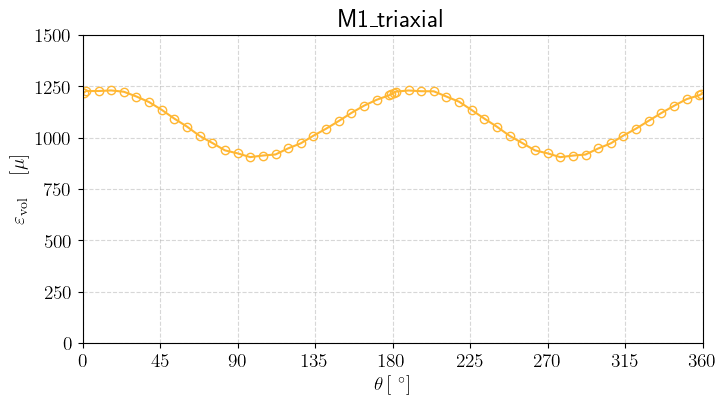

In [165]:
# run_benchmark('M1_triaxial')
postproc_benchmark('M1_triaxial', strain = 'vol')

OGS Path: ~/master_test/build_master_modifiedE/bin/ogs, PRJ File: great_cell_3d_SDprocess.prj
>>> OGS started execution ... <<<
great_cell_3d_SDprocess.prj
>>> OGS terminated execution  <<< Elapsed time:  51.47  s.


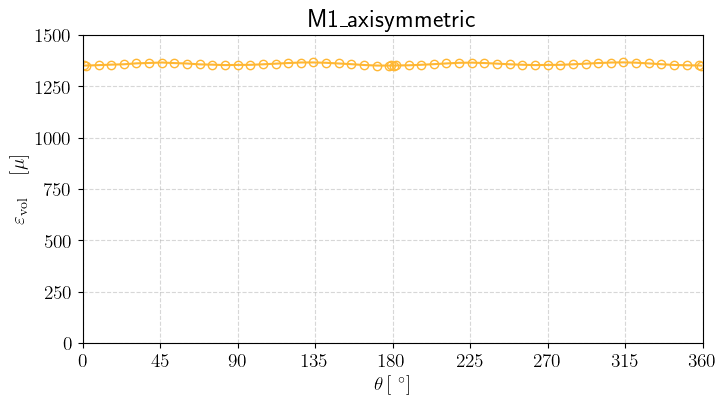

In [168]:
run_benchmark('M1_axisymmetric')
postproc_benchmark('M1_axisymmetric', strain = 'vol')

## Numerical Validation: A Comparative Study of Various Groups' Simulations Against Laboratory Experimental Data

### Data

In [169]:
#----------------------------------------------------------------------------------------------------
#UFZ--VPF/FEM--OGS6
#----------------------------------------------------------------------------------------------------
angles_vol_UFZ_tri, strain_vol_UFZ_tri = get_vol_strain(f'{results_dir}/results_M1_triaxial')
strain_vol_UFZ_flipped_tri = np.insert(np.flip(strain_vol_UFZ_tri[1:]),0, strain_vol_UFZ_tri[0])

angles_surf_UFZ_tri, strain_surf_UFZ_tri = get_surf_strain(f'{results_dir}/results_M1_triaxial')
strain_surf_UFZ_flipped_tri = np.insert(np.flip(strain_surf_UFZ_tri[1:]),0, strain_surf_UFZ_tri[0])


angles_vol_UFZ_elip_axisym, strain_vol_UFZ_elip_axisym = get_vol_strain(f'{results_dir}/results_M1_axisymmetric')
strain_vol_UFZ_elip_flipped_axisym = np.insert(np.flip(strain_vol_UFZ_elip_axisym[1:]),0, strain_vol_UFZ_elip_axisym[0])

angles_surf_UFZ_elip_axisym, strain_surf_UFZ_elip_axisym = get_surf_strain(f'{results_dir}/results_M1_axisymmetric')
strain_surf_UFZ_elip_flipped_axisym = np.insert(np.flip(strain_surf_UFZ_elip_axisym[1:]),0, strain_surf_UFZ_elip_axisym[0])

#----------------------------------------------------------------------------------------------------
#UFZ--VPF/FEM--OGS5
#----------------------------------------------------------------------------------------------------
df = pd.read_excel(r'./Data/DerivationofdataforFigure6McDermottetal2018.xlsx')
strain_surf_ogs5 = np.array(df['Unnamed: 36'][85:101])
angles_ogs5 = np.array(df['Unnamed: 34'][85:101])

strain_surf_ogs5_T2 = np.array(df['Unnamed: 36'][66:82])
angles_ogs5_T2 = np.array(df['Unnamed: 34'][66:82])

#----------------------------------------------------------------------------------------------------
#KAERI--IFDM/DEM--3DEC/TOUGH2
#----------------------------------------------------------------------------------------------------
# surface strain KAERI
kaeri_1=np.genfromtxt('./Data/Step1aSolidbodystraindata_KAERI.txt',usecols=(0,1))[3:50] #kaeri_1[:,0],kaeri_1[:,1] = angles, strain
kaeri_2=np.genfromtxt('./Data/Step1aSolidbodystraindata_KAERI.txt',usecols=(0,1))[53:100]

# volumetric strain kaeri
df = pd.read_excel(r'./Data/Task1_M1_volumetric_KAERI.xlsx')
angles_kaeri = np.array(df['LS1'][1:])
strain_vol_kaeri = np.array(df['Unnamed: 4'][1:])

angles_kaeri = np.array(df['LS1'][1:])
strain_vol_kaeri_T2 = np.array(df['Unnamed: 1'][1:])

#----------------------------------------------------------------------------------------------------
#CAS--hCA-FEM/xFEM--CASRock
#----------------------------------------------------------------------------------------------------
# surface strain CAS chinese academic of science
df = pd.read_excel(r'./Data/TaskGGREATCellResults-M-CASTeam.xlsx')
angles_CAS = np.array(df['Reference McDermott et al. 2018, figure 6'][8:])
strain_surf_CAS = np.array(df['Unnamed: 11'][8:])
#strain_surf_CAS_flipped = np.flip(strain_surf_CAS)

angles_CAS_T2 = np.array(df['Reference McDermott et al. 2018, figure 6'][8:])
strain_surf_CAS_T2 = np.array(df['Unnamed: 5'][8:])
#strain_surf_CAS_T2_flipped = np.flip(strain_surf_CAS_T2)

#----------------------------------------------------------------------------------------------------
#SNL--FEM--COMSOL
#----------------------------------------------------------------------------------------------------
# volumetric COMSOL
df = pd.read_excel(r'./Data/M1solidbodystrainmodelingresults_COMSOL_SNL_Rev1_Aug_30_23.xlsx')
angles_COMSOL =np.array(df['M1 -True Triaxial Case'][1:])
strain_vol_COMSOL = np.array(df['Unnamed: 2'][1:])

df = pd.read_excel(r'./Data/M1solidbodystrainmodelingresults_COMSOL_SNL_Rev1_Aug_30_23.xlsx', sheet_name='Axisymmetric_model')
angles_COMSOL_T2 =np.array(df['M1 -Axisymmetric Case'][1:])
strain_vol_COMSOL_T2 = np.array(df['Unnamed: 2'][1:])

#----------------------------------------------------------------------------------------------------
# UOE--Laboratory experimen
#----------------------------------------------------------------------------------------------------
df = pd.read_excel(r'./Data/DerivationofdataforFigure6McDermottetal2018.xlsx')
strain_surf_exp = np.array(df['Unnamed: 43'][28:44])
angles_exp = np.array(df['Unnamed: 42'][28:44])

strain_surf_exp_T2 = np.array(df['Unnamed: 43'][46:62])
angles_exp_T2 = np.array(df['Unnamed: 42'][46:62])

In [170]:
colors = ['#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7', '#000000']
markers = ['o', 's', 'd', '*', 'o','s']

### Mechanical tri-axial comparison

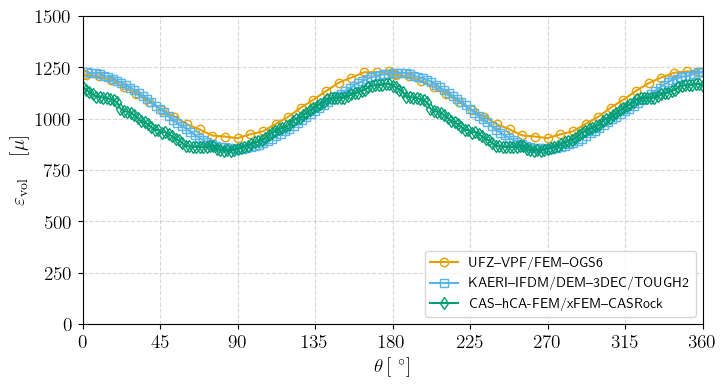

In [171]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)

plt.plot(angles_vol_UFZ_tri*180/math.pi,strain_vol_UFZ_flipped_tri*1e6,  marker=markers[0],fillstyle='none', color=colors[0], label='UFZ--VPF/FEM--OGS6')
plt.plot(angles_kaeri,strain_vol_kaeri,  marker=markers[1],fillstyle='none', color=colors[1], label='KAERI--IFDM/DEM--3DEC/TOUGH2')
plt.plot(angles_CAS,strain_surf_CAS,  marker=markers[2],fillstyle='none', color=colors[2], label='CAS--hCA-FEM/xFEM--CASRock')

plt.grid(linestyle='dashed') 
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis
plt.ylim([0,1500])
plt.xlim([0,360])
plt.ylabel(r'$\varepsilon_{\mathrm{vol}} \quad \left[\mathrm{\mu}\right]$',fontsize =14) 
plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)                
legend_ = ax.legend(loc='lower right')
plt.savefig(f'./{results_dir}/volstrain_M1_3D_tri.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()

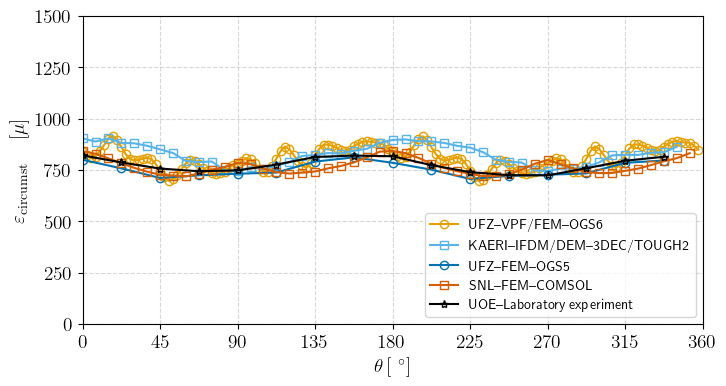

In [172]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)

plt.plot(angles_surf_UFZ_tri*180/math.pi,strain_surf_UFZ_flipped_tri*1e6,  marker=markers[0],fillstyle='none', color=colors[0], label='UFZ--VPF/FEM--OGS6')
plt.plot(kaeri_1[:,0],kaeri_1[:,1],  marker=markers[1],fillstyle='none', color=colors[1], label='KAERI--IFDM/DEM--3DEC/TOUGH2')
plt.plot(angles_ogs5,strain_surf_ogs5,  marker=markers[4],fillstyle='none', color=colors[4], label='UFZ--FEM--OGS5')
plt.plot(angles_COMSOL,strain_vol_COMSOL,  marker=markers[5],fillstyle='none', color=colors[5], label='SNL--FEM--COMSOL')
plt.plot(angles_exp,strain_surf_exp,  marker=markers[3],fillstyle='none', color='black', label='UOE--Laboratory experiment')

plt.grid(linestyle='dashed') 
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis   
plt.ylim([0,1500])
plt.xlim([0,360])
plt.ylabel(r'$\varepsilon_{\mathrm{circumst}} \quad \left[\mathrm{\mu}\right]$',fontsize =14) 
plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
# legend_ = ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
legend_ = ax.legend(loc='lower right')
plt.savefig(f'./{results_dir}/surfacestrain_M1_3D_tri.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()

### Mechanical axisymmetric comparison

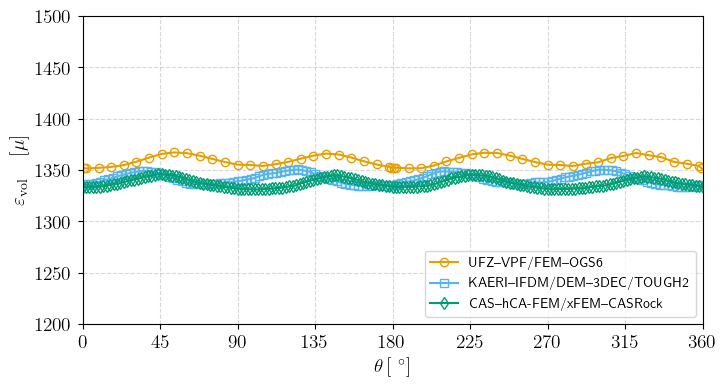

In [173]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)

plt.plot(angles_vol_UFZ_elip_axisym*180/math.pi,strain_vol_UFZ_elip_flipped_axisym*1e6,  marker=markers[0],fillstyle='none', color=colors[0], label='UFZ--VPF/FEM--OGS6')
plt.plot(angles_kaeri,strain_vol_kaeri_T2,  marker=markers[1],fillstyle='none', color=colors[1], label='KAERI--IFDM/DEM--3DEC/TOUGH2')
plt.plot(angles_CAS_T2,strain_surf_CAS_T2,  marker=markers[2],fillstyle='none', color=colors[2], label='CAS--hCA-FEM/xFEM--CASRock')

plt.grid(linestyle='dashed') 
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis
plt.ylim([1200,1500])
plt.xlim([0,360])
plt.ylabel(r'$\varepsilon_{\mathrm{vol} } \quad \left[\mathrm{\mu} \right]$',fontsize =14) 
plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
legend_ = ax.legend(loc='lower right')
plt.savefig(f'./{results_dir}/volstrain_M1_3D_axi.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()

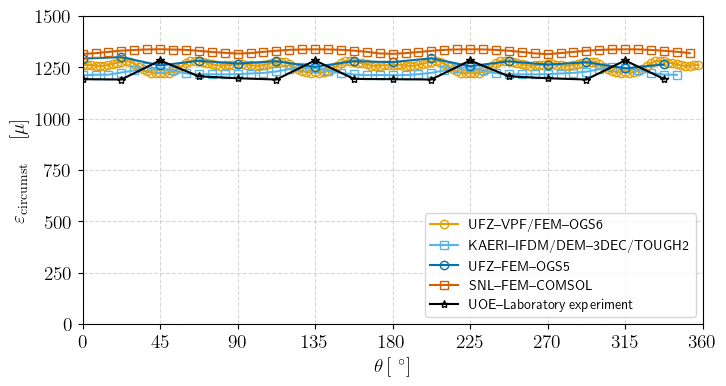

In [174]:
fig = plt.figure(figsize=(8, 4))  # Adjust width and height as needed
ax = fig.add_subplot(1, 1, 1)

plt.plot(angles_surf_UFZ_elip_axisym*180/math.pi,strain_surf_UFZ_elip_axisym*1e6,  marker=markers[0],fillstyle='none', color=colors[0], label='UFZ--VPF/FEM--OGS6')
plt.plot(kaeri_2[:,0],kaeri_2[:,1],  marker=markers[1],fillstyle='none', color=colors[1], label='KAERI--IFDM/DEM--3DEC/TOUGH2')
plt.plot(angles_ogs5_T2,strain_surf_ogs5_T2,  marker=markers[4],fillstyle='none', color=colors[4], label='UFZ--FEM--OGS5')
plt.plot(angles_COMSOL_T2,strain_vol_COMSOL_T2,  marker=markers[5],fillstyle='none', color=colors[5], label='SNL--FEM--COMSOL')
plt.plot(angles_exp_T2,strain_surf_exp_T2,  marker=markers[3],fillstyle='none', color='black', label='UOE--Laboratory experiment')

plt.grid(linestyle='dashed') 
major_ticks = np.arange(0, 370, 45)
ax.set_xticks(major_ticks)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)
ax.tick_params(axis='x', labelsize=14)  # Increase font size of x-axis
ax.tick_params(axis='y', labelsize=14)  # Increase font size of y-axis
plt.ylim([0,1500])
plt.xlim([0,360])
plt.ylabel(r'$\varepsilon_{\mathrm{circumst}} \quad \left[\mathrm{\mu}\right]$',fontsize =14)               
plt.xlabel(r'$\theta \left[~^{\circ} \right]$',fontsize =14)
legend_ = ax.legend(loc='lower right')
plt.savefig(f'./{results_dir}/surfacestrain_M1_3D_axi.pdf', format='pdf', bbox_inches='tight', dpi=400)
plt.show()

# Mechanical deformation of great cell with various material

OGS Path: ~/master_test/build_master_modifiedE/bin/ogs, PRJ File: great_cell_3d_SDprocess.prj
>>> OGS started execution ... <<<
great_cell_3d_SDprocess.prj
>>> OGS terminated execution  <<< Elapsed time:  42.55  s.
>>> OGS started execution ... <<<
great_cell_3d_SDprocess.prj
>>> OGS terminated execution  <<< Elapsed time:  43.88  s.
>>> OGS started execution ... <<<
great_cell_3d_SDprocess.prj
>>> OGS terminated execution  <<< Elapsed time:  53.7  s.


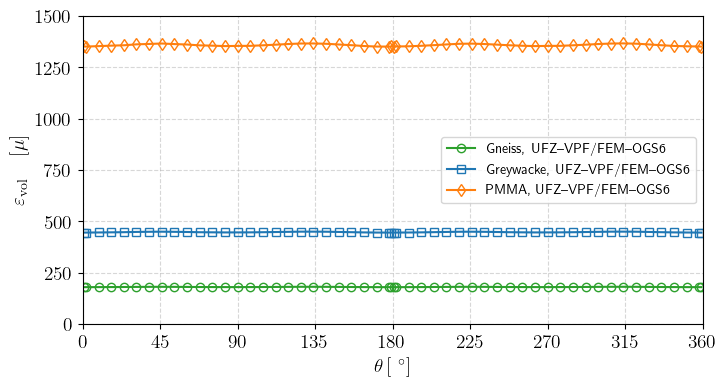

In [175]:
run_benchmark('M1_axisymmetric_differentMaterial')
postproc_benchmark('M1_axisymmetric_differentMaterial', strain = 'vol')

OGS Path: ~/master_test/build_master_modifiedE/bin/ogs, PRJ File: great_cell_3d_SDprocess.prj
>>> OGS started execution ... <<<
great_cell_3d_SDprocess.prj
>>> OGS terminated execution  <<< Elapsed time:  43.29  s.
>>> OGS started execution ... <<<
great_cell_3d_SDprocess.prj
>>> OGS terminated execution  <<< Elapsed time:  44.29  s.
>>> OGS started execution ... <<<
great_cell_3d_SDprocess.prj
>>> OGS terminated execution  <<< Elapsed time:  54.81  s.


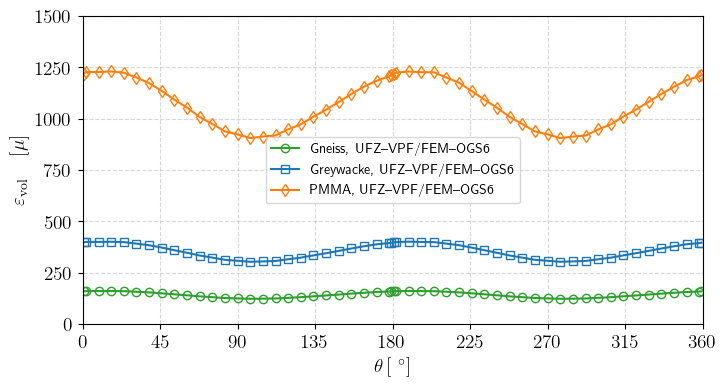

In [176]:
run_benchmark('M1_triaxial_differentMaterial')
postproc_benchmark('M1_triaxial_differentMaterial', strain = 'vol')

# Fractured samples

OGS Path: ~/dynamicPhasefield/build-THMPF-updateTao-dynamic/bin/ogs, PRJ File: great_cell_3d.prj
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  232.01  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  244.09  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  221.22  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  231.66  s.


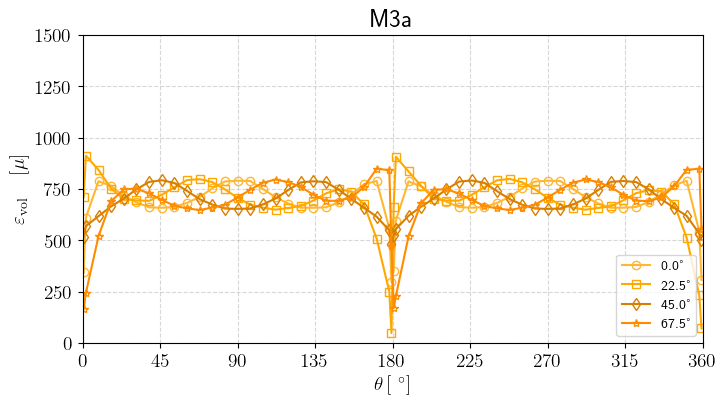

In [204]:
run_benchmark('M3a')
postproc_benchmark('M3a')

OGS Path: ~/dynamicPhasefield/build-THMPF-updateTao-dynamic/bin/ogs, PRJ File: great_cell_3d.prj
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  212.08  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  214.6  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  201.31  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  218.28  s.


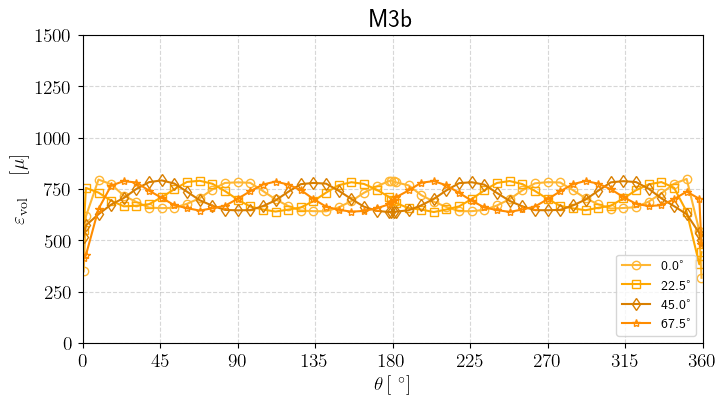

In [206]:
run_benchmark('M3b')
postproc_benchmark('M3b')

OGS Path: ~/dynamicPhasefield/build-THMPF-updateTao-dynamic/bin/ogs, PRJ File: great_cell_3d.prj
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  256.32  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  235.4  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  243.98  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  235.87  s.


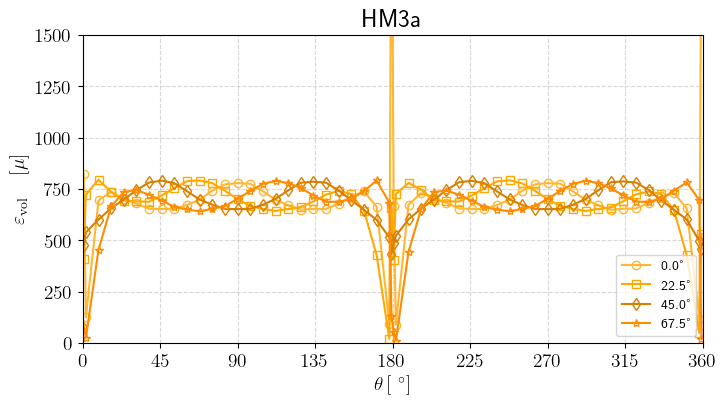

In [205]:
run_benchmark('HM3a')
postproc_benchmark('HM3a')

OGS Path: ~/dynamicPhasefield/build-THMPF-updateTao-dynamic/bin/ogs, PRJ File: great_cell_3d.prj
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  195.18  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  212.61  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  230.29  s.
>>> OGS started execution ... <<<
great_cell_3d.prj
>>> OGS terminated execution  <<< Elapsed time:  221.05  s.


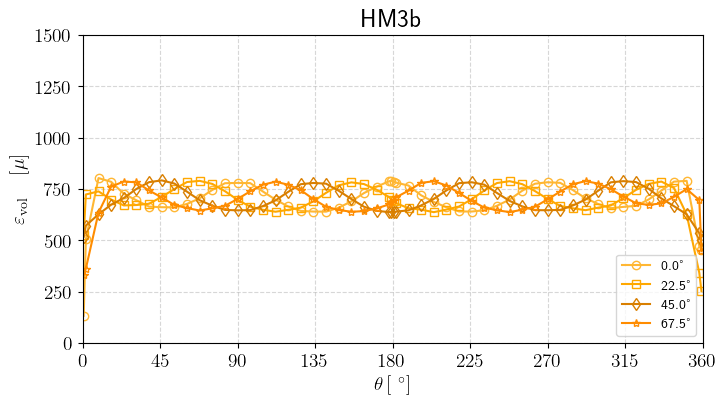

In [183]:
run_benchmark('HM3b')
postproc_benchmark('HM3b')